In [2]:
import os
import sys

os.chdir('..')


In [3]:
!pwd

/Users/alexc/Desktop/UofG/Lvl5-Project/test-suite-enhancement


# Helper scripts

In [4]:
import json

# Print out all the user prompts stored in task json
task_json_path = "data/batch_requests/batch_task_jsons/batch_tasks_100.jsonl"
with open(task_json_path, 'r') as f:
    task_jsonl = f.read()
tasks = task_jsonl.split('\n')
for task in tasks:
    if not task.strip():
        continue
    task_json = json.loads(task)
    prompts = task_json['body']['messages']
    user_prompt = next((msg['content'] for msg in prompts if msg['role'] == 'user'), None)
    print(user_prompt)


# CLASS UNDER TEST: HumanEval_99.py

def closest_integer(value):
    '''
    Create a function that takes a value (string) representing a number
    and returns the closest integer to it. If the number is equidistant
    from two integers, round it away from zero.

    Examples
    >>> closest_integer("10")
    10
    >>> closest_integer("15.3")
    15

    Note:
    Rounding away from zero means that if the given number is equidistant
    from two integers, the one you should return is the one that is the
    farthest from zero. For example closest_integer("14.5") should
    return 15 and closest_integer("-14.5") should return -15.
    '''

    from math import floor, ceil

    if value.count('.') == 1:
        # remove trailing zeros
        while (value[-1] == '0'):
            value = value[:-1]

    num = float(value)
    if value[-2:] == '.5':
        if num > 0:
            res = ceil(num)
        else:
            res = floor(num)
    elif len(value) > 0:
        res = int(rou

In [5]:
# Add a identifier value to all the batches
BATCHES_JSON = 'data/batch_requests/batch_requests.jsonl'
def add_identifier(json_path, key, value):
    with open(json_path, 'r') as f:
        task_jsonl = f.read()
    tasks = task_jsonl.split('\n')
    for i, task in enumerate(tasks):
        if not task.strip():
            continue
        task_json = json.loads(task)
        task_json['identifiers'][key] = value
        tasks[i] = json.dumps(task_json)

    with open(json_path, 'w') as f:
        f.write('\n'.join(tasks))

# add_identifier(BATCHES_JSON, 'flag', 'old_1')


In [6]:
from src.evaluation_entry import EvaluationEntry

def add_identifier_to_eval_entries():
    # Add an identifier to all the eval entries whose batch has the flag 'old_1'
    eval_entries = EvaluationEntry.load_all("enhanced", "human_eval")
    for eval_entry in eval_entries:
        print(eval_entry.eval_id)
        print(eval_entry.type)
        # eval_entry.save()
    
# add_identifier_to_eval_entries()


In [7]:
from src.evaluation_entry import EvaluationEntry

# Update the enhanced metrics from string to json
def convert_enhanced_entry_metrics():
    eval_entries = EvaluationEntry.load_all("enhanced", "human_eval")
    for eval_entry in eval_entries:
        if type(eval_entry.eval_data["enhanced_project_evaluation"]) == str:
            try:
                eval_entry.eval_data["enhanced_project_evaluation"] = json.loads(eval_entry.eval_data["enhanced_project_evaluation"])
                eval_entry.eval_data["enhanced_test_evaluation"] = json.loads(eval_entry.eval_data["enhanced_test_evaluation"])
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON for eval entry {eval_entry.eval_id}: {e}")
                continue
            # eval_entry.save()
    
# convert_enhanced_entry_metrics()

In [8]:
# Remove tha task_path from all the new batches
BATCHES_JSON = 'data/batch_requests/batch_requests.jsonl'
def remove_task_path(json_path):
    with open(json_path, 'r') as f:
        task_jsonl = f.read()
    tasks = task_jsonl.split('\n')
    for i, task in enumerate(tasks):
        if not task.strip():
            continue
        
        task_json = json.loads(task)
        # print(task_json["batch_id"])
        identifiers = task_json['identifiers']
        if 'flag' in identifiers and identifiers['flag'] == 'old_1':
            continue
        
        task_json['task_json'] = None
        tasks[i] = json.dumps(task_json)

    with open(json_path, 'w') as f:
        f.write('\n'.join(tasks))

# remove_task_path(BATCHES_JSON)

In [9]:
# Regenerate eval_id

def regenerate_eval_id(type):
    eval_entries = EvaluationEntry.load_all(type, "human_eval")

    def get_new_id(eval_entry:EvaluationEntry):
        new_eval_id = ""
        # enum = eval_entry.get_evalId_number()
        if eval_entry.type == "initial":
            new_eval_id = "/".join([
                str(eval_entry.get_evalId_number()),
                eval_entry.get_test_source()
            ]).lower()
        else:
            new_eval_id = "/".join([
                str(eval_entry.get_evalId_number()),
                eval_entry.get_test_source(),
                eval_entry.identifiers["test_selection_mode"],
                str(eval_entry.identifiers["num_test_cases"])
            ]).lower()

        return new_eval_id

    for eval_entry in eval_entries:
        print("Old eval id = " + eval_entry.eval_id)
        print(eval_entry.type)
        
        eval_entry.eval_id = get_new_id(eval_entry)
        print("New eval id = " + eval_entry.eval_id)
        # eval_entry.save()

# regenerate_eval_id("initial")

# Evaluation

1. Create a chart/table for correctness metrics
2. Create a chart/table for coverage metrics
3. Create a chart/table for code quality metrics

In [10]:
# Transform the task_json to csv
import pandas as pd
from IPython.display import display

def get_initial_eval_entry_csv(project_name):
    eval_entries = EvaluationEntry.load_all("initial", project_name)
    data = []

    for eval_entry in eval_entries:
        eval_entry_data = eval_entry.get_eval_entry_csv()
        data.append(eval_entry_data)
    
    init_dfs = pd.concat(data, ignore_index=True)
    # display(init_dfs)
    return init_dfs

initial_data = get_initial_eval_entry_csv('human_eval')
display(initial_data)


,eval_id,test_source,num_test_cases,test_selection_mode,total_classes,total_tests,passed,passed_after_repair,syntax_errors,syntax_errors_after_repair,...,cognitive_complexity,cyclomatic_complexity,squale_index,code_smells,bugs,vulnerabilities,syntactically_correct,syntactically_correct_after_repair,compilable,compilable_after_repair
0,0/pynguin,pynguin,None,None,164,515,211,210,0,0,...,0,211,1106,185,0,0,164,164,164,164
1,1/chatgpt,chatgpt,None,None,164,1170,0,969,0,0,...,0,969,164,25,25,0,164,164,163,164
2,2/human_written,human_written,None,None,164,1181,1172,1172,0,0,...,2,1175,796,103,12,0,164,164,164,164


## Correctness evaluation

In [11]:
def create_correctness_table(df):
    correctness_cols = [
        'total_tests',
        'total_classes',
        'syntactically_correct',
        'syntactically_correct_after_repair',
        'compilable',
        'compilable_after_repair',
        'passed',
        'passed_after_repair',
        # 'no_test_classes_after_repair'
    ]

    # Create correctness table
    melted = df.melt(
        id_vars=['test_source'],
        value_vars=correctness_cols,
        var_name='metric',
        value_name='value'
    )
    correctness_table = melted.pivot(index='metric', columns='test_source', values='value').fillna(0).astype(int)
    correctness_table = correctness_table.reindex(correctness_cols)
    # Sort the table by the order of correctness_cols
    

    # Create percentage table
    percentage_table = correctness_table.copy().astype(float)

    for col in percentage_table.columns:
        total_tests = percentage_table.loc['total_tests', col]
        total_classes = percentage_table.loc['total_classes', col]
        for idx in percentage_table.index:
            if idx != 'total_tests' and idx != 'total_classes':
                if idx in ['passed', 'passed_after_repair']:
                    total = total_tests
                else:
                    total = total_classes
                percentage_table.loc[idx, col] = (percentage_table.loc[idx, col] / total * 100) if total > 0 else 0.0
            else:
                percentage_table.loc[idx, col] = None  # No % for total_classes

    # Format values
    percentage_table = percentage_table.applymap(
        lambda x: f"{x:.2f}%" if pd.notna(x) else ""
    )
    correctness_table = correctness_table.astype(str)
    percentage_table.index = [f"{i} (%)" if i != 'total_tests' else '' for i in correctness_table.index]

    # Combine both tables
    combined_table = pd.concat([correctness_table, percentage_table])
    combined_table = combined_table[combined_table.index != '']

    # Display
    print(combined_table)
    

create_correctness_table(initial_data)

test_source                             chatgpt human_written  pynguin
total_tests                                1170          1181      515
total_classes                               164           164      164
syntactically_correct                       164           164      164
syntactically_correct_after_repair          164           164      164
compilable                                  163           164      164
compilable_after_repair                     164           164      164
passed                                        0          1172      211
passed_after_repair                         969          1172      210
total_classes (%)                                                     
syntactically_correct (%)               100.00%       100.00%  100.00%
syntactically_correct_after_repair (%)  100.00%       100.00%  100.00%
compilable (%)                           99.39%       100.00%  100.00%
compilable_after_repair (%)             100.00%       100.00%  100.00%
passed

/var/folders/z7/grqfp40j73xcvr_rkz8n20hm0000gn/T/ipykernel_4068/2970448760.py:43: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  percentage_table = percentage_table.applymap(


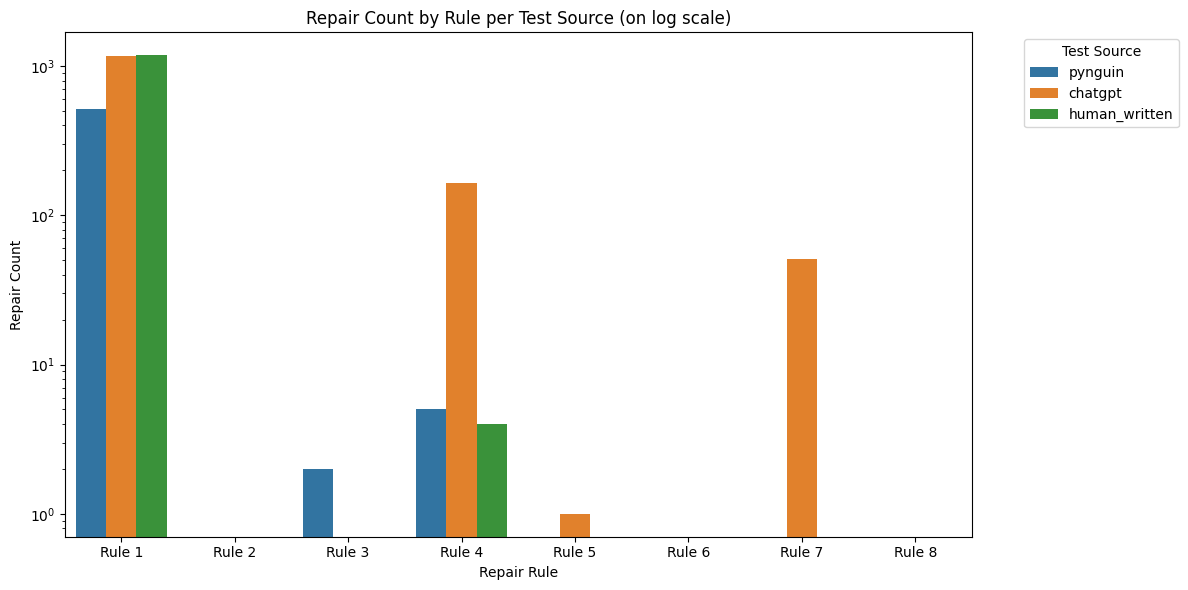

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_rule_repair_figure(df:pd.DataFrame):
    repair_cols = [col for col in df.columns if col.endswith('_repair_count') and col.startswith('rule_')]

    melted_df = df.melt(
        id_vars=['test_source'],
        value_vars=repair_cols,
        var_name='rule',
        value_name='repair_count'
    )
    melted_df['rule'] = melted_df['rule'].str.replace('_repair_count', '').str.replace('rule_', 'Rule ')

    plt.figure(figsize=(12, 6))
    sns.barplot(data=melted_df, x='rule', y='repair_count', hue='test_source')

    plt.yscale('log') # Use log scale to better visualize the differences

    plt.title('Repair Count by Rule per Test Source (on log scale)')
    plt.xlabel('Repair Rule')
    plt.ylabel('Repair Count')
    plt.legend(title='Test Source', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

create_rule_repair_figure(initial_data)

In [13]:
def create_rule_repair_table(df):
    repair_cols = [col for col in df.columns if col.endswith('_repair_count') and col.startswith('rule_')]

    melted_df = df.melt(
        id_vars=['test_source'],
        value_vars=repair_cols,
        var_name='rule',
        value_name='repair_count'
    )
    
    table_df = melted_df.pivot(index='rule', columns='test_source', values='repair_count')
    table_df = table_df.fillna(0).astype(int)

    print(table_df)

create_rule_repair_table(initial_data)

test_source          chatgpt  human_written  pynguin
rule                                                
rule_1_repair_count     1170           1181      515
rule_2_repair_count        0              0        0
rule_3_repair_count        0              0        2
rule_4_repair_count      164              4        5
rule_5_repair_count        1              0        0
rule_6_repair_count        0              0        0
rule_7_repair_count       51              0        0
rule_8_repair_count        0              0        0


## Coverage evaluation

In [14]:
# Coverage metrics

def create_coverage_table(df, settings=None):
    coverage_cols = [
        "coverage",
        "branch_coverage",
        "line_coverage",
        "lines_to_cover",
        "uncovered_lines"
    ]
    
    # Make the value which is None as id_var
    if settings is not None:
        id_var = next((k for k, v in settings.items() if v is None), None)
    else:
        id_var = 'test_source'
        settings = 'initial'
    
    # Create correctness table
    melted = df.melt(
        id_vars=[id_var],
        value_vars=coverage_cols,
        var_name='metric',
        value_name='value'
    )
    coverage_table = melted.pivot(index='metric', columns=id_var, values='value').fillna(0)
    coverage_table = coverage_table.reindex(coverage_cols)
    # Sort the table by the order of coverage_cols

    # Format values
    coverage_table = coverage_table.astype(str)

    # Display
    print(f"INFO: {settings}")
    print(coverage_table)

data = initial_data.copy()
display(data)
create_coverage_table(data)

,eval_id,test_source,num_test_cases,test_selection_mode,total_classes,total_tests,passed,passed_after_repair,syntax_errors,syntax_errors_after_repair,...,cognitive_complexity,cyclomatic_complexity,squale_index,code_smells,bugs,vulnerabilities,syntactically_correct,syntactically_correct_after_repair,compilable,compilable_after_repair
0,0/pynguin,pynguin,None,None,164,515,211,210,0,0,...,0,211,1106,185,0,0,164,164,164,164
1,1/chatgpt,chatgpt,None,None,164,1170,0,969,0,0,...,0,969,164,25,25,0,164,164,163,164
2,2/human_written,human_written,None,None,164,1181,1172,1172,0,0,...,2,1175,796,103,12,0,164,164,164,164


INFO: initial
test_source     chatgpt human_written pynguin
metric                                       
coverage           97.8          98.5    83.5
branch_coverage    92.8          95.5    64.0
line_coverage      98.6          99.0    88.0
lines_to_cover     3900          3849    2696
uncovered_lines      55            39     324


In [61]:
def get_enhanced_eval_data(project, settings):
    eval_entries = EvaluationEntry.load_all("enhanced", project)
    data = []
    for eval_entry in eval_entries:
        if "flag" in eval_entry.identifiers and eval_entry.identifiers["flag"] == "old_1":
            continue
        if settings.get('test_source') and eval_entry.get_test_source() != settings['test_source']:
            continue
        if settings.get('test_selection_mode') and eval_entry.identifiers['test_selection_mode'] != settings['test_selection_mode']:
            continue
        if settings.get('num_test_cases') and eval_entry.identifiers['num_test_cases'] != settings['num_test_cases']:
            continue
        data.append(eval_entry.get_eval_entry_csv())
    
    enhanced_dfs = pd.concat(data, ignore_index=True)
    return enhanced_dfs

settings = {
    'test_source': None,
    'test_selection_mode': 'random_from_all',
    'num_test_cases': 3
}

enhanced_dfs = get_enhanced_eval_data("human_eval", settings)
display(enhanced_dfs)
create_coverage_table(enhanced_dfs, settings)

,eval_id,test_source,num_test_cases,test_selection_mode,total_classes,total_tests,passed,passed_after_repair,syntax_errors,syntax_errors_after_repair,...,cognitive_complexity,cyclomatic_complexity,squale_index,code_smells,bugs,vulnerabilities,syntactically_correct,syntactically_correct_after_repair,compilable,compilable_after_repair
0,1/human_written/random_from_all/3,human_written,3,random_from_all,164,1139,1139,1139,0,0,...,3,1140,461,45,27,0,164,164,164,164
1,19/pynguin/random_from_all/3,pynguin,3,random_from_all,164,1482,90,1128,0,0,...,1,1053,365,47,29,0,164,164,164,164
2,37/chatgpt/random_from_all/3,chatgpt,3,random_from_all,164,1090,1090,1090,0,0,...,0,1090,250,29,30,0,164,164,164,164


INFO: {'test_source': None, 'test_selection_mode': 'random_from_all', 'num_test_cases': 3}
test_source     chatgpt human_written pynguin
metric                                       
coverage           96.3          98.2    97.9
branch_coverage    85.7          94.0    91.2
line_coverage      97.8          98.8    98.8
lines_to_cover     4241          4201    4409
uncovered_lines      94            52      53


# Code quality evaluation

In [16]:
# Code quality metrics

def create_code_quality_table(df, settings=None):
    code_quality_cols = [
        "lines",
        "non_comment_lines",
        "comment_lines",
        "cognitive_complexity",
        "cyclomatic_complexity",
        "squale_index",
        "code_smells",
        # "bugs",
        # "vulnerabilities"
    ]
    
    # Make the value which is None as id_var
    if settings is not None:
        id_var = next((k for k, v in settings.items() if v is None), None)
    else:
        id_var = 'test_source'
        settings = 'initial'
    
    # Create correctness table
    melted = df.melt(
        id_vars=[id_var],
        value_vars=code_quality_cols,
        var_name='metric',
        value_name='value'
    )
    code_quality_table = melted.pivot(index='metric', columns=id_var, values='value').fillna(0)
    code_quality_table = code_quality_table.reindex(code_quality_cols)
    # Sort the table by the order of coverage_cols

    # Format values
    code_quality_table = code_quality_table.astype(str)

    # Display
    print(f"INFO: {settings}")
    print(code_quality_table)

data = initial_data.copy()
display(data)
create_code_quality_table(data)

,eval_id,test_source,num_test_cases,test_selection_mode,total_classes,total_tests,passed,passed_after_repair,syntax_errors,syntax_errors_after_repair,...,cognitive_complexity,cyclomatic_complexity,squale_index,code_smells,bugs,vulnerabilities,syntactically_correct,syntactically_correct_after_repair,compilable,compilable_after_repair
0,0/pynguin,pynguin,None,None,164,515,211,210,0,0,...,0,211,1106,185,0,0,164,164,164,164
1,1/chatgpt,chatgpt,None,None,164,1170,0,969,0,0,...,0,969,164,25,25,0,164,164,163,164
2,2/human_written,human_written,None,None,164,1181,1172,1172,0,0,...,2,1175,796,103,12,0,164,164,164,164


INFO: initial
test_source           chatgpt human_written pynguin
metric                                             
lines                    3891          4700    2547
non_comment_lines        2748          2708    1526
comment_lines              52            90     326
cognitive_complexity        0             2       0
cyclomatic_complexity     969          1175     211
squale_index              164           796    1106
code_smells                25           103     185


In [17]:
settings = {
    'test_source': None,
    'test_selection_mode': 'random_from_all',
    'num_test_cases': 1
}
enhanced_dfs = get_enhanced_eval_data("human_eval", settings)
display(enhanced_dfs)
create_code_quality_table(enhanced_dfs, settings)

,eval_id,test_source,num_test_cases,test_selection_mode,total_classes,total_tests,passed,passed_after_repair,syntax_errors,syntax_errors_after_repair,...,cognitive_complexity,cyclomatic_complexity,squale_index,code_smells,bugs,vulnerabilities,syntactically_correct,syntactically_correct_after_repair,compilable,compilable_after_repair
0,0/human_written/random_from_all/1,human_written,1,random_from_all,164,1312,0,1021,0,0,...,7,1023,461,45,34,0,164,164,164,164
1,18/pynguin/random_from_all/1,pynguin,1,random_from_all,164,1149,1117,1117,2,2,...,3,972,656,71,34,0,162,162,164,164
2,36/chatgpt/random_from_all/1,chatgpt,1,random_from_all,164,1079,1079,1079,1,1,...,3,1081,334,36,31,0,163,163,164,164


INFO: {'test_source': None, 'test_selection_mode': 'random_from_all', 'num_test_cases': 1}
test_source           chatgpt human_written pynguin
metric                                             
lines                    4525          4242    4580
non_comment_lines        3185          2981    3275
comment_lines             170           163     397
cognitive_complexity        3             7       3
cyclomatic_complexity    1081          1023     972
squale_index              334           461     656
code_smells                36            45      71


In [18]:
def create_code_quality_table_2(df, settings=None):
    code_quality_cols = [
        "lines",
        "non_comment_lines",
        "comment_lines",
        "cognitive_complexity",
        "cyclomatic_complexity",
        "squale_index",
        "code_smells",
        # "bugs",
        # "vulnerabilities"
    ]
    
    # Make the value which is None as id_var
    if settings is not None:
        id_var = [k for k, v in settings.items() if v is None]
    else:
        id_var = ['test_source']
        settings = 'initial'
    
    # Create correctness table
    melted = df.melt(
        id_vars=id_var,
        value_vars=code_quality_cols,
        var_name='metric',
        value_name='value'
    )
    code_quality_table = melted.pivot(index='metric', columns=id_var, values='value').fillna(0)
    code_quality_table = code_quality_table.reindex(code_quality_cols)
    # Sort the table by the order of coverage_cols

    # Format values
    code_quality_table = code_quality_table.astype(str)

    # Display
    print(f"INFO: {settings}")
    print(code_quality_table)

settings = {
    'test_source': "chatgpt",
    'test_selection_mode': None,
    'num_test_cases': 1
}
enhanced_dfs = get_enhanced_eval_data("human_eval", settings)
display(enhanced_dfs)
create_code_quality_table_2(enhanced_dfs, settings)

,eval_id,test_source,num_test_cases,test_selection_mode,total_classes,total_tests,passed,passed_after_repair,syntax_errors,syntax_errors_after_repair,...,cognitive_complexity,cyclomatic_complexity,squale_index,code_smells,bugs,vulnerabilities,syntactically_correct,syntactically_correct_after_repair,compilable,compilable_after_repair
0,36/chatgpt/random_from_all/1,chatgpt,1,random_from_all,164,1079,1079,1079,1,1,...,3,1081,334,36,31,0,163,163,164,164


INFO: {'test_source': 'chatgpt', 'test_selection_mode': None, 'num_test_cases': 1}
test_selection_mode   random_from_all
metric                               
lines                            4525
non_comment_lines                3185
comment_lines                     170
cognitive_complexity                3
cyclomatic_complexity            1081
squale_index                      334
code_smells                        36


,eval_id,test_source,num_test_cases,test_selection_mode,total_classes,total_tests,passed,passed_after_repair,syntax_errors,syntax_errors_after_repair,...,cognitive_complexity,cyclomatic_complexity,squale_index,code_smells,bugs,vulnerabilities,syntactically_correct,syntactically_correct_after_repair,compilable,compilable_after_repair
0,18/pynguin/random_from_all/1,pynguin,1,random_from_all,164,1149,1117,1117,2,2,...,3,972,656,71,34,0,162,162,164,164
1,19/pynguin/random_from_all/3,pynguin,3,random_from_all,164,1482,90,1128,0,0,...,1,1053,365,47,29,0,164,164,164,164
2,20/pynguin/random_from_all/5,pynguin,5,random_from_all,164,1097,1077,1077,5,5,...,1,951,756,108,29,0,159,159,164,164
3,21/pynguin/random_from_class_under_test/1,pynguin,1,random_from_class_under_test,164,1095,1093,1093,17,17,...,3,1057,544,43,17,0,147,147,162,162
4,22/pynguin/random_from_class_under_test/3,pynguin,3,random_from_class_under_test,164,963,952,952,22,22,...,8,1047,635,69,24,0,142,142,148,148
5,23/pynguin/random_from_class_under_test/5,pynguin,5,random_from_class_under_test,164,877,858,861,25,23,...,5,1028,811,73,8,0,139,141,144,144
6,24/pynguin/problem_similarity/1,pynguin,1,problem_similarity,164,1141,1119,1119,3,3,...,5,993,608,57,40,0,161,161,164,164
7,25/pynguin/problem_similarity/3,pynguin,3,problem_similarity,164,1057,1025,1025,5,4,...,4,902,422,45,29,0,159,160,162,161
8,26/pynguin/problem_similarity/5,pynguin,5,problem_similarity,164,1082,1046,1046,5,5,...,0,1005,559,76,25,0,159,159,159,159
9,27/pynguin/class_similarity_no_definition/1,pynguin,1,class_similarity_no_definition,164,1138,1117,1117,4,4,...,0,987,608,63,38,0,160,160,164,164


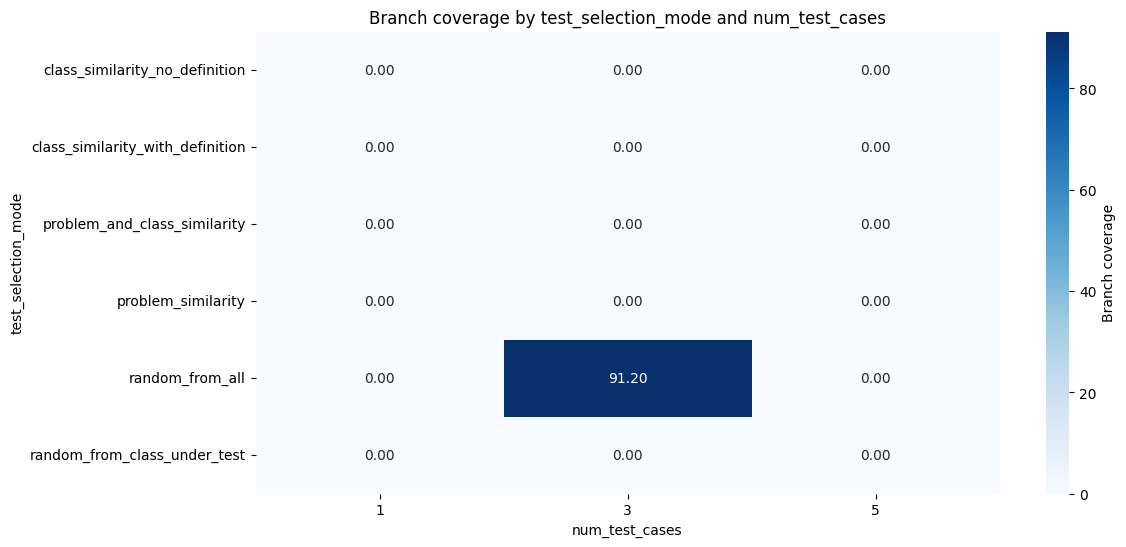

In [56]:
# Chart

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def create_code_coverage_chart(df, settings=None, display_variable="coverage"):
    # Validate input
    if settings is None:
        settings = {'test_source': None, 'test_selection_mode': None, 'num_test_cases': 1}
    
    # Identify varying and fixed variables
    varying_vars = [k for k, v in settings.items() if v is None]
    fixed_vars = {k: v for k, v in settings.items() if v is not None}

    if len(varying_vars) != 2:
        raise ValueError("Exactly 2 variables must vary (be set to `None`).")

    # Filter data based on fixed settings
    mask = pd.Series(True, index=df.index)
    for key, val in fixed_vars.items():
        mask &= (df[key] == val)
    df_filtered = df[mask]

    # Ensure display_variable exists in the DataFrame
    if display_variable not in df_filtered.columns:
        raise ValueError(f"Column {display_variable} not found in the DataFrame.")
    
    # Convert display_variable to numeric, coercing errors (e.g., strings) to NaN
    df_filtered[display_variable] = pd.to_numeric(
        df_filtered[display_variable],
        errors='coerce'  # Convert non-numeric to NaN
    )
    
    # Drop rows where 'coverage' is NaN (if any conversion failed)
    df_filtered = df_filtered.dropna(subset=[display_variable]) 

    # Pivot data for plotting
    pivot_df = df_filtered.pivot(
        index=varying_vars[0],
        columns=varying_vars[1],
        values=display_variable
    ).fillna(0)

    # Plotting
    label = display_variable.replace("_", " ").capitalize()
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': label})
    plt.title(f"{label} by {varying_vars[0]} and {varying_vars[1]}")
    plt.xlabel(varying_vars[1])
    plt.ylabel(varying_vars[0])
    plt.show()

# Example usage
settings = {
    'test_source': "pynguin",
    'test_selection_mode': None,
    'num_test_cases': None  # Vary two variables
}

enhanced_dfs = get_enhanced_eval_data("human_eval", settings)
display(enhanced_dfs)
create_code_coverage_chart(enhanced_dfs, settings, "branch_coverage")

In [20]:
import numpy as np
filtered_values = enhanced_dfs[enhanced_dfs['syntax_errors_after_repair'] != 0]["no_test_classes_after_repair"].tolist()
print(filtered_values)# Debug what is the problem with - coverage for certain eval entries
import src.utility_functions as uf

[5, 7, 1, 2, 3, 3, 7, 3, 4, 6, 5, 4, 7, 3, 4, 5, 4]


In [60]:
eval_id = "37/chatgpt/random_from_all/3"

test_source = eval_id.split("/")[1]
project_name = "human_eval"
test_folder = "_".join(eval_id.split("/")[1:])
test_folder_path = f"data/{project_name}/tests/{test_source}/enhanced/{test_folder}/"
target_folder_path = f"tmp/{project_name}/tests/{test_source}/"

uf.copy_python_files(test_folder_path, target_folder_path)

In [59]:

uf.delete_python_files(target_folder_path)
uf.delete_repository(target_folder_path)


In [23]:
original_file = "import pytest\n\nclass TestHumanEval:\n\n    def test_is_palindrome_with_palindrome(self):\n        assert is_palindrome(\"racecar\") is True\n\n    def test_is_palindrome_with_non_palindrome(self):\n        assert is_palindrome(\"hello\") is False\n\n    def test_is_palindrome_with_empty_string(self):\n        assert is_palindrome(\"\") is True\n\n    def test_is_palindrome_with_single_character(self):\n        assert is_palindrome(\"a\") is True\n\n    def test_is_palindrome_with_mixed_case(self):\n        assert is_palindrome(\"Aba\") is False\n\n    def test_make_palindrome_with_empty_string(self):\n        assert make_palindrome('') == ''\n\n    def test_make_palindrome_with_single_character(self):\n        assert make_palindrome('a') == 'a'\n\n    def test_make_palindrome_with_non_palindrome(self):\n        assert make_palindrome('cat') == 'catac'\n\n    def test_make_palindrome_with_palindromic_suffix(self):\n        assert make_palindrome('civic') == 'civic'\n\n    def test_make_palindrome_with_long_string(self):\n        assert make_palindrome('abcd') == 'abcddcba'\n\n    def test_make_palindrome_with_already_palindrome(self):\n        assert make_palindrome('madam') == 'madam'\n\n    def test_make_palindrome_with_special_characters(self):\n        assert make_palindrome('a!b') == 'a!b!a'\n\n    def test_make_palindrome_with_numeric_string(self):\n        assert make_palindrome('123') == '12321'\n"
print(original_file)

import pytest

class TestHumanEval:

    def test_is_palindrome_with_palindrome(self):
        assert is_palindrome("racecar") is True

    def test_is_palindrome_with_non_palindrome(self):
        assert is_palindrome("hello") is False

    def test_is_palindrome_with_empty_string(self):
        assert is_palindrome("") is True

    def test_is_palindrome_with_single_character(self):
        assert is_palindrome("a") is True

    def test_is_palindrome_with_mixed_case(self):
        assert is_palindrome("Aba") is False

    def test_make_palindrome_with_empty_string(self):
        assert make_palindrome('') == ''

    def test_make_palindrome_with_single_character(self):
        assert make_palindrome('a') == 'a'

    def test_make_palindrome_with_non_palindrome(self):
        assert make_palindrome('cat') == 'catac'

    def test_make_palindrome_with_palindromic_suffix(self):
        assert make_palindrome('civic') == 'civic'

    def test_make_palindrome_with_long_string(self):
    